# Image inference of Mask R-CNN with Monte-Carlo dropout

### Initialize a few paths

In [1]:
weightsfolder = "./weights/broccoli"
resultsfolder = "./results/broccoli"
dataroot = "./datasets/mrcnn"

### Import the most common libraries

In [2]:
## general libraries
import time
import torch
import numpy as np
import os
import cv2
import random
import warnings
import operator
from collections import OrderedDict
from tqdm import tqdm
warnings.filterwarnings("ignore")

## detectron2-libraries 
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
       
# run on gpu 0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Register the datasets 

In [3]:
register_coco_instances("broccoli_test", {}, os.path.join(dataroot, "test", "annotations.json"), os.path.join(dataroot, "test"))
broccoli_test_metadata = MetadataCatalog.get("broccoli_test")
dataset_dicts_test = DatasetCatalog.get("broccoli_test")

[03/26 13:35:59 d2.data.datasets.coco]: Loaded 607 images in COCO format from ./datasets/mrcnn/test/annotations.json


### Add dropout layers to the architecture of Mask R-CNN

In [4]:
from active_learning.strategies.dropout import FastRCNNConvFCHeadDropout
from active_learning.strategies.dropout import FastRCNNOutputLayersDropout

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_BOX_HEAD.NAME = 'FastRCNNConvFCHeadDropout'
cfg.MODEL.ROI_HEADS.NAME = 'StandardROIHeadsDropout'
cfg.MODEL.ROI_HEADS.SOFTMAXES = True

### Initialize the inference parameters

In [5]:
cfg.DATASETS.TEST = ("broccoli_test",)
cfg.NUM_GPUS = 1
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = weightsfolder
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # broccoli, damaged, matured, cateye, headrot
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01

### Monte-Carlo inference and uncertainty sampling

In [6]:
from active_learning.sampling.montecarlo_dropout import MonteCarloDropout
from active_learning.sampling import observations
from active_learning.heuristics import uncertainty

iterations = 5
batch_size = 5
iou_thres = 0.5
pool_size = 50
pool = {}

device = cfg.MODEL.DEVICE
predictor = MonteCarloDropout(cfg, iterations, batch_size)

for d in tqdm(dataset_dicts_test):
    filename = d["file_name"].split('/')[-1].split('.')[0]
    img = cv2.imread(d["file_name"])
    width, height = img.shape[:-1]

    outputs = predictor(img)
    obs = observations(outputs, iou_thres)
    img_uncertainty = uncertainty(obs, iterations, width, height, device) ## reduce the iterations when facing a "CUDA out of memory" error

    if len(pool) < pool_size:
        pool[filename] = float(img_uncertainty)
    else:
        max_id, max_val = max(pool.items(), key=operator.itemgetter(1))
        if float(img_uncertainty) < max_val:
            del pool[max_id]
            pool[filename] = float(img_uncertainty)

100%|██████████| 607/607 [04:44<00:00,  2.13it/s]


### Visualize a few uncertain images

Sampled image: 20160810_142149


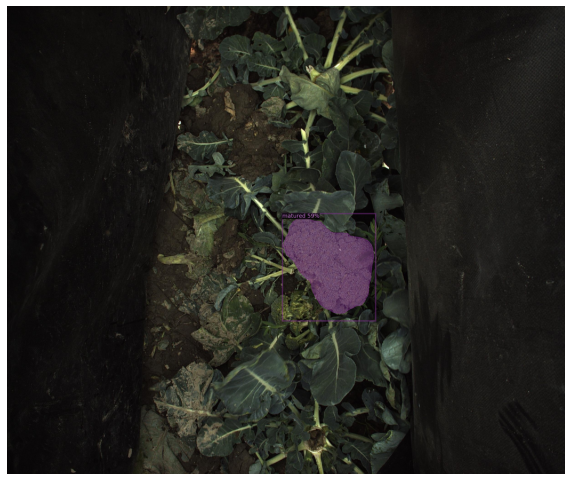

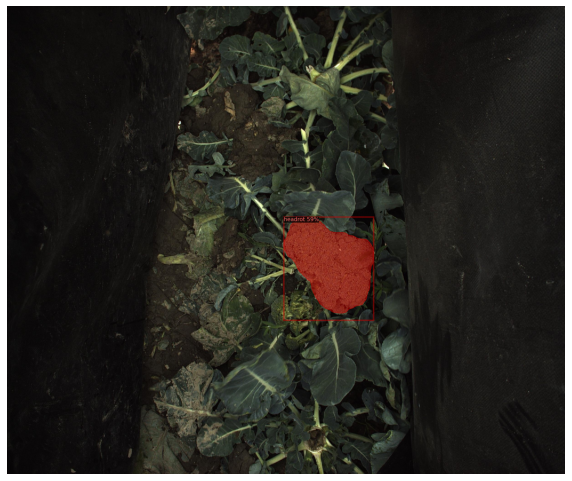

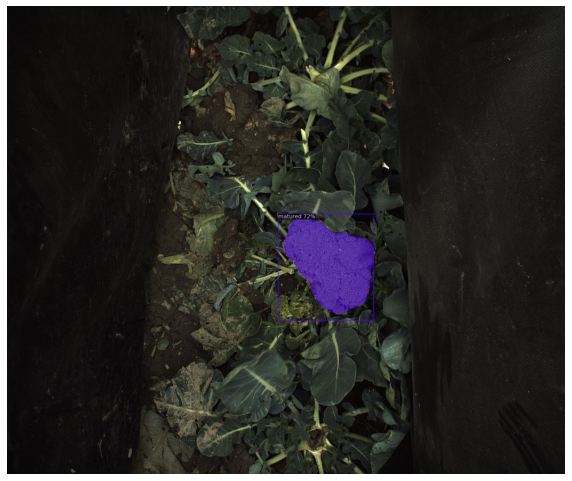

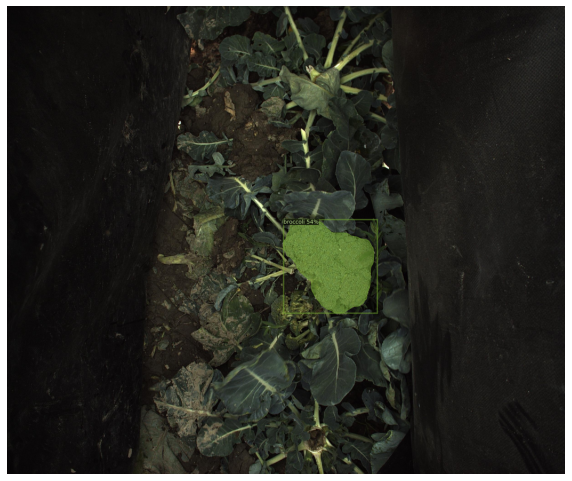

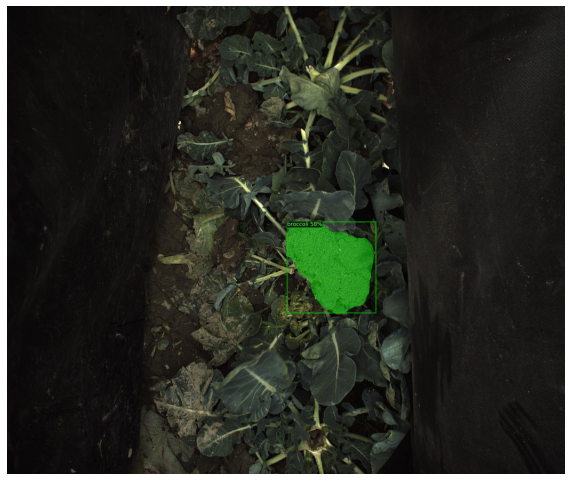

Sampled image: 20181017_102213404_RGB


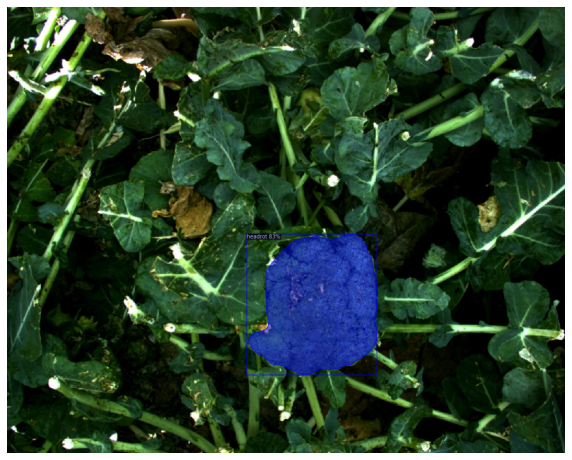

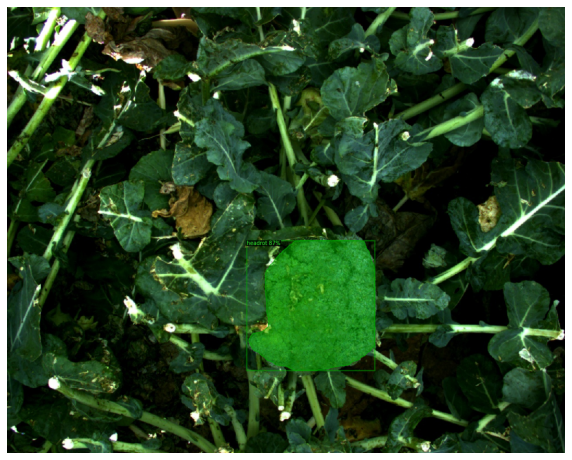

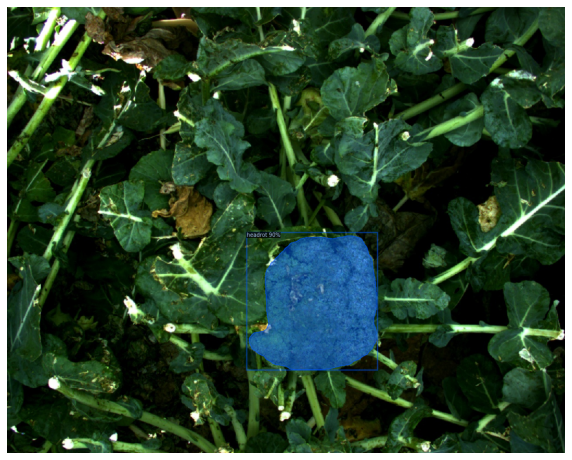

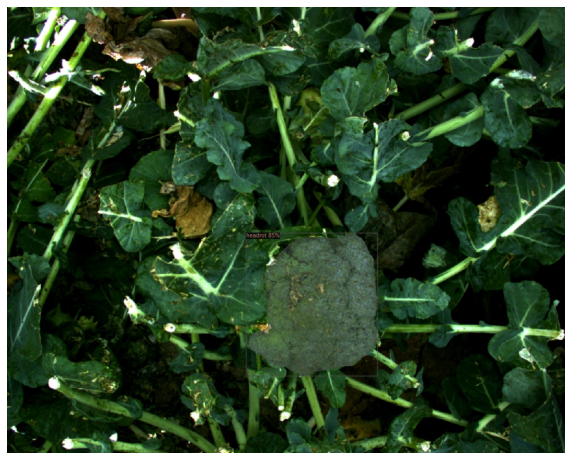

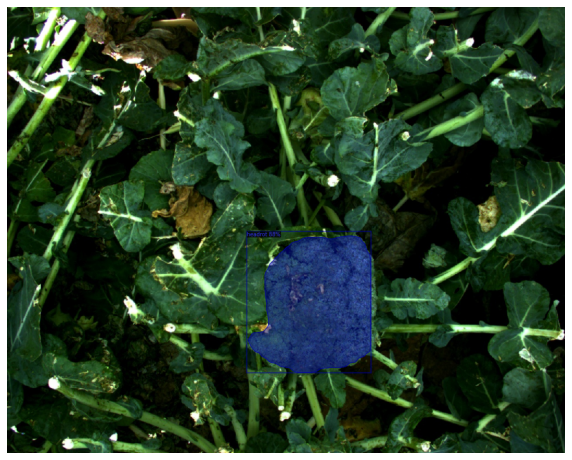

In [7]:
sorted_pool = sorted(pool.items(), key=operator.itemgetter(1))
pool = {}
for k, v in sorted_pool:
    pool[k] = v    

for name, cert in random.sample(pool.items(), 2):
    for d in dataset_dicts_test:
        filename = d["file_name"].split('/')[-1].split('.')[0]
        
        if name == filename:
            print("Sampled image: {:s}".format(filename))
            img = cv2.imread(d["file_name"])
            outputs = predictor(img)
            
            for i in range(iterations):
                visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_test_metadata, scale=0.8)
                vis = visualizer.draw_instance_predictions(outputs[i]["instances"].to("cpu"))
                imshow(vis.get_image()[:, :, ::-1])